In [1]:
import os

from sklearn import set_config
set_config(display = "diagram")

import pandas as pd
import numpy as np 
import shap

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge, Lasso

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import SCORERS

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

2023-03-03 10:21:40.537164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-03 10:21:40.537193: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [3]:
cwd = os.getcwd()
cwd

'/home/bryan/OpenClassRoom/Seattle'

In [4]:
source = 'data/cleaned/'
filename = 'df_clean2.csv'
df = pd.read_csv(source + filename, index_col = 0)

In [5]:
df.shape

(2384, 43)

In [6]:
cond = df['ENERGYSTARScore'].isna()
rqdIndex = df[cond].index
df.drop(rqdIndex, axis = 0, inplace = True)

In [7]:
df.shape

(1646, 43)

## Train Test Split

In [8]:
target = 'TotalGHGEmissions'

In [9]:
X = df.copy().drop([target], axis =1)
y = df.copy()[target]

In [10]:
df['TotalGHGEmissions_q'] = pd.qcut(df['TotalGHGEmissions'],10)
df['TotalGHGEmissions_q'].value_counts()

(-0.801, 6.045]        165
(6.045, 10.98]         165
(20.095, 30.79]        165
(46.45, 65.25]         165
(94.635, 148.55]       165
(269.605, 16870.98]    165
(10.98, 20.095]        164
(30.79, 46.45]         164
(65.25, 94.635]        164
(148.55, 269.605]      164
Name: TotalGHGEmissions_q, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size =0.3,
                                                    random_state = 18,
                                                    shuffle = True,
                                                    stratify = df['TotalGHGEmissions_q'])

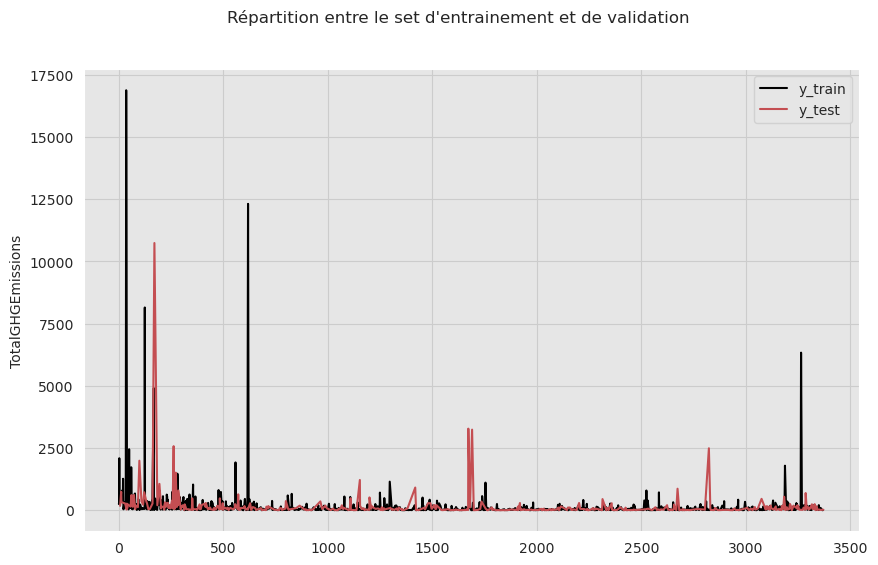

In [12]:
fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y= y_train, color ='black', label ='y_train', ax =ax)
sns.lineplot(x=y_test.index, y = y_test, color = sns_c[3], label ='y_test', ax=ax)
plt.suptitle("Répartition entre le set d'entrainement et de validation")
plt.show()

## Model Development

### Features

In [13]:
numeric_features = [
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'Electricity_p',
    'NaturalGaz_p',
    'Latitude',
    'Longitude',
    'NonResidentialGFA',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'ENERGYSTARScore']


categorical_features = [
    'PrimaryPropertyType',
    'BuildingType',
    'LargestPropertyUseType']

features = numeric_features + categorical_features

In [14]:
X_train = X_train[features]
X_test = X_test[features]

### Preprocessor

In [15]:
#centrage et réduction des données
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

In [16]:
#transformation des variables categorielles
categorical_transformer = Pipeline(steps = [
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'))
])

In [17]:
#Recuperation des noms de colonnes apres les transformations
categorical_features_ext = list(categorical_transformer['one_hot']\
                                .fit(X_train[categorical_features])\
                                .get_feature_names_out()
                               )
features_ext = categorical_features_ext + numeric_features
print(f'Number of features after preprocessing: {len(features_ext)}')

Number of features after preprocessing: 59


## Linear Model

In [18]:
#preprocessor
linear_preprocessor = ColumnTransformer(transformers = [
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features),
], remainder = 'passthrough')

In [19]:
#engineering
linear_feature_engineering = Pipeline(steps = [
    ('linear_preprocessor', linear_preprocessor),
    ('polynomial', PolynomialFeatures(degree = 2, include_bias = False)),
    ('variance_threshold', VarianceThreshold())
])

In [20]:
#modele
linear_pipeline = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('linear_regressor', Lasso(max_iter = 8000))
])

In [21]:
#Recherche des meilleurs hyperparametres
linear_param_grid = {
    'linear_regressor__alpha' : np.logspace(-3,3,20),
    'linear_feature_engineering__polynomial__interaction_only' : [True, False]
}

linear_grid_search = GridSearchCV(
    estimator = linear_pipeline,
    param_grid = linear_param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 2,
    n_jobs = -1
)

In [22]:
linear_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('linear_feature_engineering',
                                        Pipeline(steps=[('linear_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           Standar...
                         'linear_regressor__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [23]:
linear_grid_search.best_params_

{'linear_feature_engineering__polynomial__interaction_only': True,
 'linear_regressor__alpha': 2.976351441631316}

In [24]:
linear_pipeline.set_params(**linear_grid_search.best_params_).fit(X_train, y_train)
linear_pipeline.score(X_test, y_test)

0.9139321961044853

## Tree Model (Adaboost)

In [25]:
#mise en place d'un preprocessor (différent du modèle lineaire)
tree_preprocessor = ColumnTransformer(transformers = [
    ('cat', categorical_transformer, categorical_features)
], remainder = 'passthrough')

In [26]:
#feature_engineering (composé que d'un preprocessor)
tree_feature_engineering = Pipeline(steps = [
    ('tree_preprocessor', tree_preprocessor)
])

In [27]:
#modele
estimateur = DecisionTreeRegressor()
tree_pipeline = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ('tree_regressor', AdaBoostRegressor(estimateur,learning_rate = 0.5))
])

In [28]:
AdaBoostRegressor.__init__

<function sklearn.ensemble._weight_boosting.AdaBoostRegressor.__init__(self, base_estimator=None, *, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)>

In [29]:
#Recherche des meilleurs hyperparamètres
tree_param_grid = {
    'tree_regressor__base_estimator__max_depth': [3, 5, 8, 13],
    'tree_regressor__n_estimators' : [50,100,150] ,
    'tree_regressor__learning_rate' : [0.1, 0.5,1],
    'tree_regressor__base_estimator__min_weight_fraction_leaf' : [0.01, 0.5],   
}

tree_grid_search = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=tree_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose = -1
)
tree_grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree_feature_engineering',
                                        Pipeline(steps=[('tree_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType'])]))])),
                                       ('tree_regressor',
                                        AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                                          learning_rate=0.5))]),
             n_jobs=-1,
             param_grid={'tree_regressor__base_estimator__max_depth': [3, 5, 8,
                                                                       13],
                         'tree_regressor__base_estimator__min_weight_fraction_leaf': [0.01,
                                                                                      0.5],
                         'tree_regressor__learning_rate': [0.1, 0.5, 1],
                         'tree_regressor__n_estimators': [50, 100, 150]},
             scoring='neg_root_mean_squared_error', verbose=-1)

In [30]:
tree_grid_search = tree_grid_search.fit(X_train,y_train)

In [31]:
tree_grid_search.best_params_

{'tree_regressor__base_estimator__max_depth': 8,
 'tree_regressor__base_estimator__min_weight_fraction_leaf': 0.01,
 'tree_regressor__learning_rate': 0.5,
 'tree_regressor__n_estimators': 150}

In [32]:
tree_pipeline.set_params(**tree_grid_search.best_params_).fit(X_train, y_train)
tree_pipeline.score(X_test, y_test)

0.778206065787652

## Model Performance

In [33]:
y_train_pred_linear = linear_pipeline.predict(X_train)
y_test_pred_linear = linear_pipeline.predict(X_test)
y_train_pred_tree = tree_pipeline.predict(X_train)
y_test_pred_tree = tree_pipeline.predict(X_test)

In [34]:
print(f'''
--------------------------------
train mse (linear): {mean_squared_error(y_train, y_train_pred_linear,squared = False): 0.2f}
test  mse (linear): {mean_squared_error(y_test, y_test_pred_linear,squared = False): 0.2f}
--------------------------------
train mse (tree)  : {mean_squared_error(y_train, y_train_pred_tree,squared = False): 0.2f}
test  mse (tree)  : {mean_squared_error(y_test, y_test_pred_tree,squared = False): 0.2f}
--------------------------------
''')


--------------------------------
train mse (linear):  78.32
test  mse (linear):  166.88
--------------------------------
train mse (tree)  :  55.09
test  mse (tree)  :  267.89
--------------------------------



In [35]:
#On calcul l'erreur
error_train_linear = y_train - y_train_pred_linear
error_test_linear = y_test - y_test_pred_linear
error_train_tree = y_train - y_train_pred_tree
error_test_tree = y_test - y_test_pred_tree

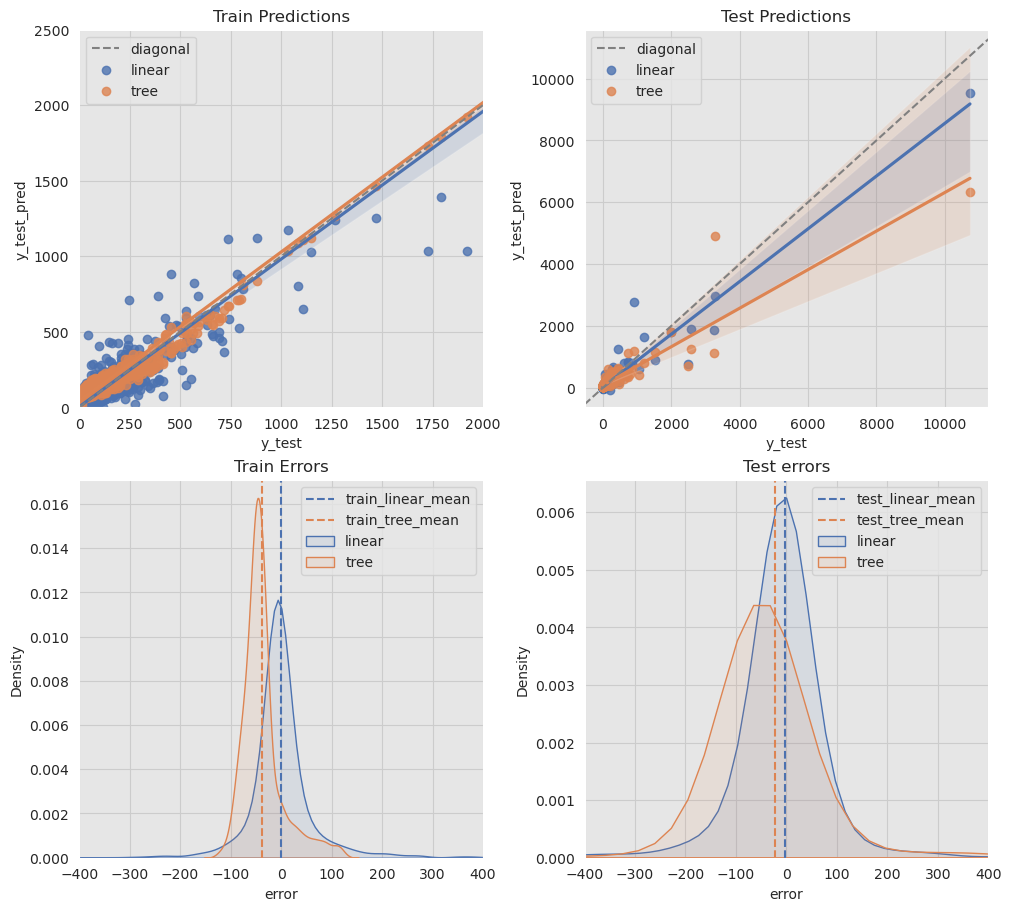

In [36]:
fig, ax = plt.subplots(2,2,figsize=(10,9), constrained_layout = True)
ax = ax.flatten()

sns.regplot(x=y_train, y=y_train_pred_linear, color=sns_c[0], label='linear', ax=ax[0])
sns.regplot(x=y_train, y=y_train_pred_tree, color=sns_c[1], label='tree', ax=ax[0])
ax[0].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[0].legend(loc='upper left')
ax[0].set(title='Train Predictions', xlabel='y_test', ylabel='y_test_pred')
ax[0].set_xlim(0,2000)
ax[0].set_ylim(0,2500)

sns.regplot(x=y_test, y=y_test_pred_linear, color=sns_c[0], label='linear', ax=ax[1])
sns.regplot(x=y_test, y=y_test_pred_tree, color=sns_c[1], label='tree', ax=ax[1])
ax[1].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[1].legend(loc='upper left')
ax[1].set(title='Test Predictions', xlabel='y_test', ylabel='y_test_pred')

sns.kdeplot(x=error_train_linear, color=sns_c[0], label='linear', fill=True, alpha=0.1, ax=ax[2])
sns.kdeplot(x=error_train_tree, color=sns_c[1], label='tree', fill=True, alpha=0.1, ax=ax[2])
ax[2].axvline(x=error_train_linear.mean(), color=sns_c[0], linestyle='--', label='train_linear_mean')
ax[2].axvline(x=error_train_tree.mean(), color=sns_c[1], linestyle='--', label='train_tree_mean')
ax[2].legend(loc='upper right')
ax[2].set(title='Train Errors', xlabel='error')
ax[2].set_xlim(-400,400)

sns.kdeplot(x=error_test_linear, color=sns_c[0], label='linear', fill=True, alpha=0.1, ax=ax[3])
sns.kdeplot(x=error_test_tree, color=sns_c[1], label='tree', fill=True, alpha=0.1, ax=ax[3])
ax[3].axvline(x=error_test_linear.mean(), color=sns_c[0], linestyle='--', label='test_linear_mean')
ax[3].axvline(x=error_test_tree.mean(), color=sns_c[1], linestyle='--', label='test_tree_mean')
ax[3].legend(loc='upper right')
ax[3].set(title='Test errors', xlabel= 'error')
ax[3].set_xlim(-400,400)



plt.show()

# Model Interpretation

### Linear Model

In [37]:
#extraction des variables explicatives apres transformation
polynomial_features = linear_pipeline[:-1].get_feature_names_out()
len(polynomial_features)

738

In [38]:
#autre methode
#Polynomial features names
polynomial_features = linear_grid_search.best_estimator_['linear_feature_engineering']['polynomial']\
.get_feature_names_out(features_ext)
len(polynomial_features)

1770

In [39]:
#Mask for variables with zero-variance
variance_threshold_support = linear_grid_search\
.best_estimator_['linear_feature_engineering']['variance_threshold'] \
    .get_support()
variance_threshold_support

array([ True,  True,  True, ...,  True,  True,  True])

In [40]:
from itertools import compress
linear_features = list(
    compress(data=polynomial_features, selectors=variance_threshold_support)
)

In [41]:
#on retombe sur le resultat de la premiere méthode
len(linear_features)

738

### coefficients de la regression

In [42]:
data = {'linear_features' : linear_features,
        'coef_' : linear_pipeline[-1].coef_}
linear_model_coef_df = pd.DataFrame(data)
linear_model_coef_df

,linear_features,coef_
0,PrimaryPropertyType_Distribution Center,-0.000000
1,PrimaryPropertyType_High-Rise Multifamily,0.000000
2,PrimaryPropertyType_Hospital,0.000000
3,PrimaryPropertyType_Hotel,0.000000
4,PrimaryPropertyType_K-12 School,-0.000000
...,...,...
733,NonResidentialGFA PropertyGFABuilding(s),0.000000
734,NonResidentialGFA ENERGYSTARScore,-24.875916
735,PropertyGFAParking PropertyGFABuilding(s),0.000000
736,PropertyGFAParking ENERGYSTARScore,0.000000


In [43]:
#création d'une colonne avec la valeur absolue des coefs
linear_model_coef_df=linear_model_coef_df.assign(abs_coef_ = lambda x : x['coef_'].abs())

In [44]:
linear_model_coef_df=linear_model_coef_df.sort_values(by='abs_coef_', ascending =False).reset_index(drop = True)

In [45]:
linear_model_coef_df

,linear_features,coef_,abs_coef_
0,PrimaryPropertyType_Hospital LargestPropertyUs...,567.259296,567.259296
1,LargestPropertyUseType_Data Center SecondLarge...,204.434390,204.434390
2,NonResidentialGFA,119.847380,119.847380
3,LargestPropertyUseType_Hospital (General Medic...,107.800452,107.800452
4,LargestPropertyUseTypeGFA Electricity_p,-104.555839,104.555839
...,...,...,...
733,PrimaryPropertyType_Residence Hall PropertyGFA...,0.000000,0.000000
734,PrimaryPropertyType_Residence Hall ENERGYSTARS...,0.000000,0.000000
735,PrimaryPropertyType_Retail Store BuildingType_...,0.000000,0.000000
736,PrimaryPropertyType_Retail Store LargestProper...,-0.000000,0.000000


In [46]:
# Get top (abs) beta coefficients.
linear_model_coef_df.head(20).style.background_gradient(cmap='viridis_r',axis=0,subset=['abs_coef_'])

,linear_features,coef_,abs_coef_
0,PrimaryPropertyType_Hospital LargestPropertyUseTypeGFA,567.259296,567.259296
1,LargestPropertyUseType_Data Center SecondLargestPropertyUseTypeGFA,204.434390,204.434390
2,NonResidentialGFA,119.847380,119.847380
3,LargestPropertyUseType_Hospital (General Medical & Surgical) LargestPropertyUseTypeGFA,107.800452,107.800452
4,LargestPropertyUseTypeGFA Electricity_p,-104.555839,104.555839
5,Electricity_p,-83.521215,83.521215
6,LargestPropertyUseTypeGFA ENERGYSTARScore,-80.688763,80.688763
7,SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseTypeGFA,58.100114,58.100114
8,SecondLargestPropertyUseTypeGFA ENERGYSTARScore,51.654203,51.654203
9,PropertyGFABuilding(s),48.598561,48.598561


### Intercept

In [47]:
linear_model_intercept = linear_grid_search.best_estimator_['linear_regressor'].intercept_
linear_model_intercept

119.60017400688452

In [48]:
linear_model_effects = np.multiply(
    linear_grid_search.best_estimator_['linear_regressor'].coef_,
    linear_grid_search.best_estimator_['linear_feature_engineering'].transform(X_train)
)

In [49]:
linear_model_effects_2 = np.multiply(
    linear_pipeline[-1].coef_,
    linear_pipeline[0].transform(X_train).todense()
)

In [50]:
linear_model_effects_df = pd.DataFrame(
    data=linear_model_effects_2,
    columns=linear_features
)
linear_model_effects_df

,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Mixed Use Property,...,Longitude NonResidentialGFA,Longitude PropertyGFAParking,Longitude PropertyGFABuilding(s),Longitude ENERGYSTARScore,NonResidentialGFA PropertyGFAParking,NonResidentialGFA PropertyGFABuilding(s),NonResidentialGFA ENERGYSTARScore,PropertyGFAParking PropertyGFABuilding(s),PropertyGFAParking ENERGYSTARScore,PropertyGFABuilding(s) ENERGYSTARScore
0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.461871,-0.0,-0.0,-0.0
1,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,5.403309,0.0,-0.0,0.0
2,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.776166,-0.0,0.0,0.0
3,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,10.006332,0.0,-0.0,0.0
4,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.244203,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,8.442755,0.0,-0.0,0.0
1148,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,7.544586,0.0,-0.0,0.0
1149,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.188839,0.0,0.0,-0.0
1150,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,-18.703156,-0.0,-0.0,-0.0


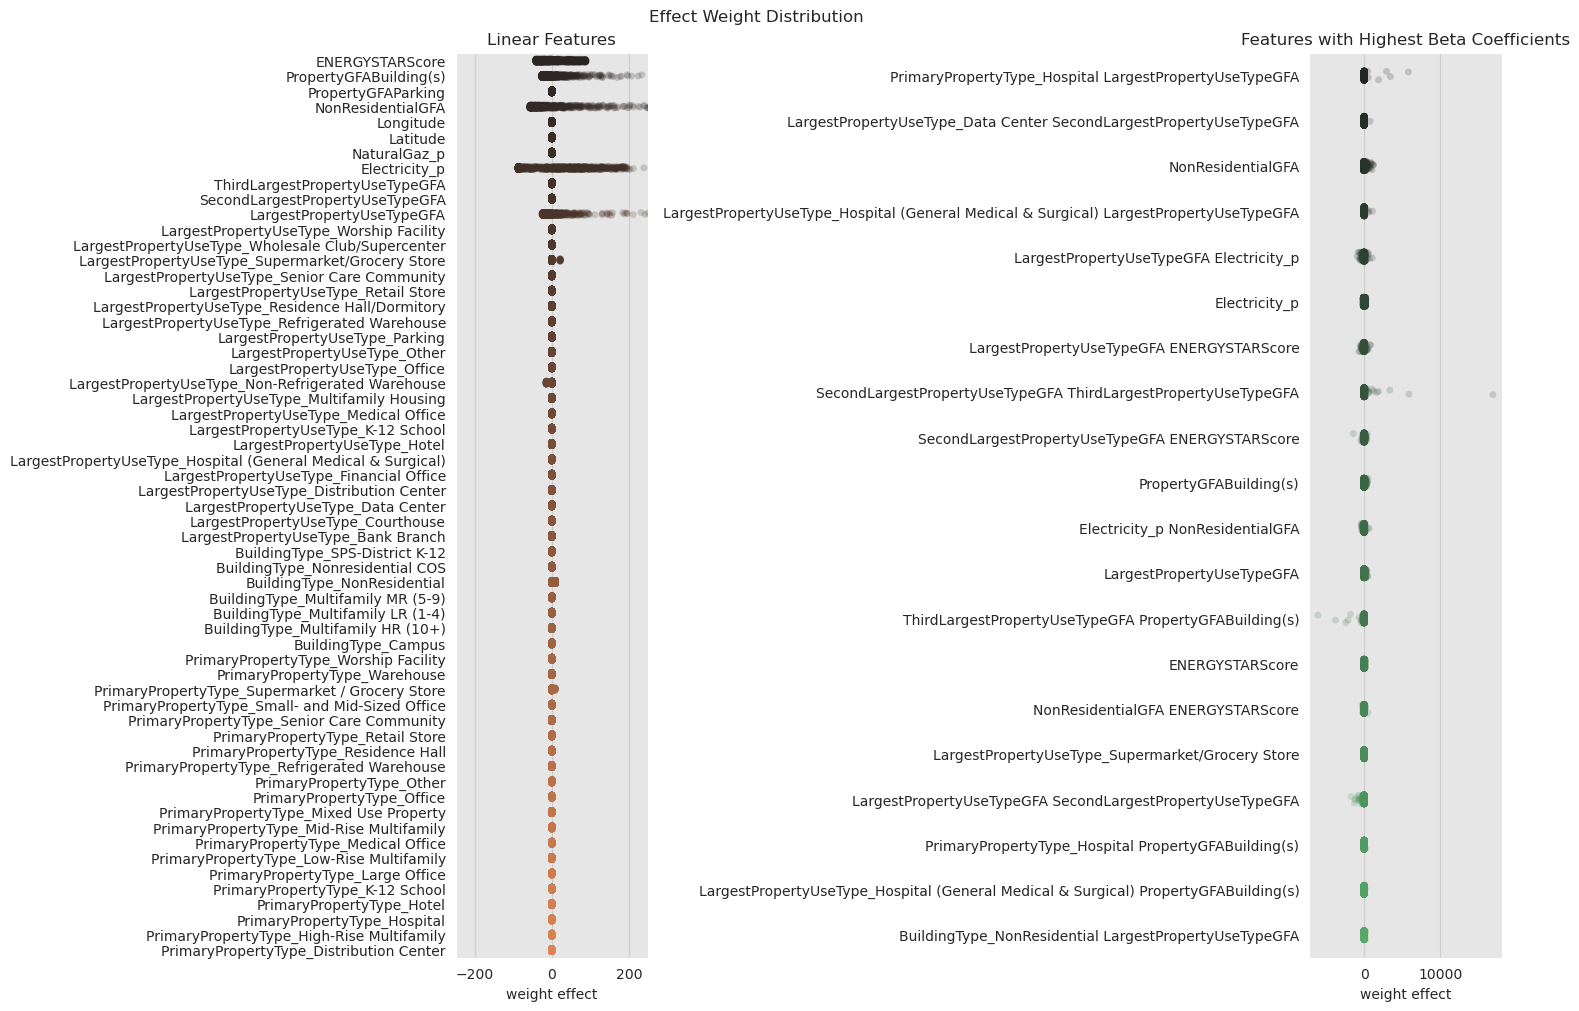

In [51]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), constrained_layout=True) 
# Weight effects distribution of the all linear terms.
sns.stripplot(
    data=linear_model_effects_df[features_ext[::-1]],
    orient='h',
    palette='dark:#dd8452',
    alpha=0.2,
    ax=ax[0]
)
ax[0].set(title='Linear Features',xlabel='weight effect')
ax[0].set_xlim(-250,250)

# Weight effects distribution of the terms 
# (including intraction) with highest beta coefficients;
sns.stripplot(
    data=linear_model_effects_df[linear_model_coef_df.head(20)['linear_features']],
    orient='h',
    palette='dark:#55a868',
    alpha=0.2,
    ax=ax[1]
)
ax[1].set(
    title='Features with Highest Beta Coefficients',
    xlabel='weight effect'
)
fig.suptitle('Effect Weight Distribution');

plt.show()

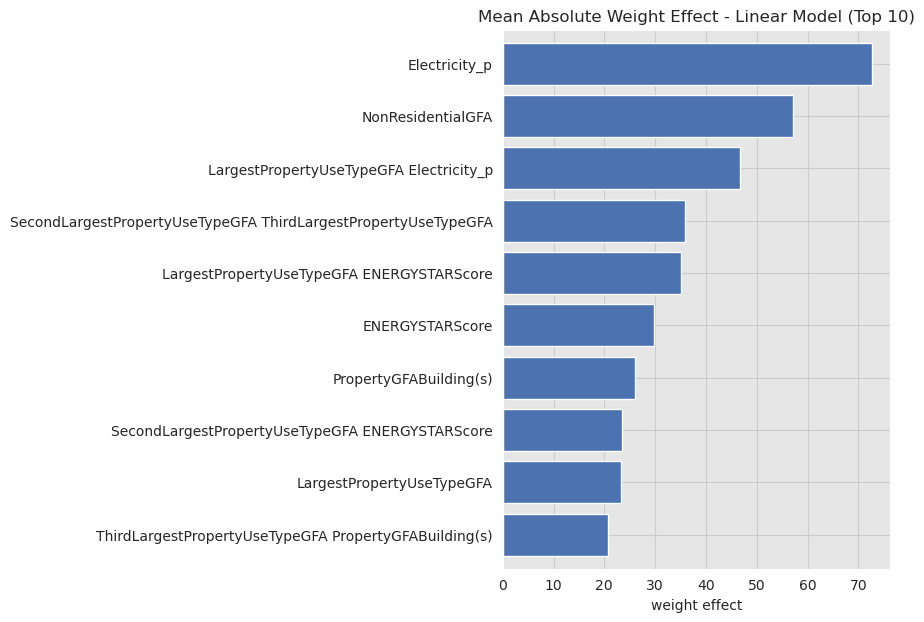

In [104]:
fig, ax = plt.subplots(figsize=(5, 7))
linear_model_effects_df.abs().mean(axis=0).sort_values().tail(10).plot(kind='barh',ax=ax,align='center',  width = 0.8)
ax.set(title='Mean Absolute Weight Effect - Linear Model (Top 10)',xlabel='weight effect')
plt.show()

## Permutation Importance

### Methode 1 

In [53]:
from sklearn.inspection import permutation_importance

In [54]:
linear_pi = permutation_importance(
    estimator=linear_grid_search,
    X=X_train,
    y=y_train,
    n_repeats=10
)
#retourn a dictionnary with 3 keys :('importances_mean', 'importances_std','importances')
linear_pi['importances'].shape

(14, 10)

In [55]:
linear_pi.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [56]:
tree_pi = permutation_importance(
    estimator = tree_grid_search,
    X = X_train,
    y=y_train,
    n_repeats = 10
)
tree_pi['importances'].shape

(14, 10)

In [57]:
#récupération des index ordonnées (decroissant)
linear_perm_sorted_idx = linear_pi.importances_mean.argsort()[::-1]
tree_perm_sorted_idx = tree_pi.importances_mean.argsort()[::-1]

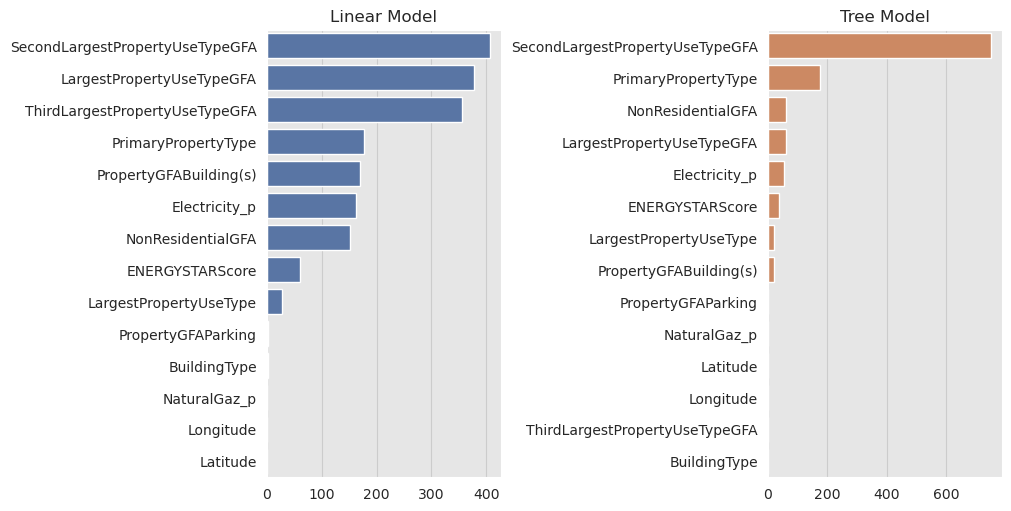

In [58]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)

sns.barplot(
    x=linear_pi.importances_mean[linear_perm_sorted_idx],
    y=X_train.columns[linear_perm_sorted_idx],
    orient='h',
    color=sns_c[0],
    ax=ax[0]
)

sns.barplot(
    x=tree_pi.importances_mean[tree_perm_sorted_idx],
    y=X_train.columns[tree_perm_sorted_idx],
    orient='h',
    color=sns_c[1],
    ax=ax[1]
)

ax[0].set(title='Linear Model')
ax[1].set(title='Tree Model');

## Shape

In [59]:
import shap

In [60]:
data=linear_grid_search.best_estimator_['linear_feature_engineering'].transform(X_train).todense()
linear_x_train = pd.DataFrame(data=data,columns=linear_features)

In [61]:
linear_x_train.shape

(1152, 738)

In [62]:
#creation de l'echantillon
linear_x_train_summary = shap.kmeans(X=linear_x_train, k=20)
linear_x_train_summary

In [63]:
linear_shap_explainer = shap.KernelExplainer(
    model=linear_grid_search.best_estimator_['linear_regressor'].predict,
    data=linear_x_train_summary,
)

In [64]:
 masker=shap.maskers.Independent(data=linear_x_train, max_samples=500)
linear_shap_explainer = shap.LinearExplainer(
    model=linear_grid_search.best_estimator_['linear_regressor'],
    masker=masker# Background data.
)
linear_shap_explainer

In [65]:
masker.data.shape

(500, 738)

In [66]:
linear_shap_values = linear_shap_explainer(linear_x_train)
print(f"{linear_shap_values.values.shape}{linear_shap_values.base_values.shape},{linear_shap_values.data.shape}")

(1152, 738)(1152,),(1152, 738)


In [67]:
linear_shap_values.base_values

array([180.85499047, 180.85499047, 180.85499047, ..., 180.85499047,
       180.85499047, 180.85499047])

In [68]:
linear_shap_explainer.expected_value

180.85499047116514

## Basic decision plot features

### Calcul de la SHAP values et des interaction pour les 20 premieres observations

In [97]:
expected_value = linear_shap_explainer.expected_value
expected_value
print(f"Explainer expected value: {expected_value}")


select = range(20)
features = X_test.iloc[select]


Explainer expected value: 180.85499047116514


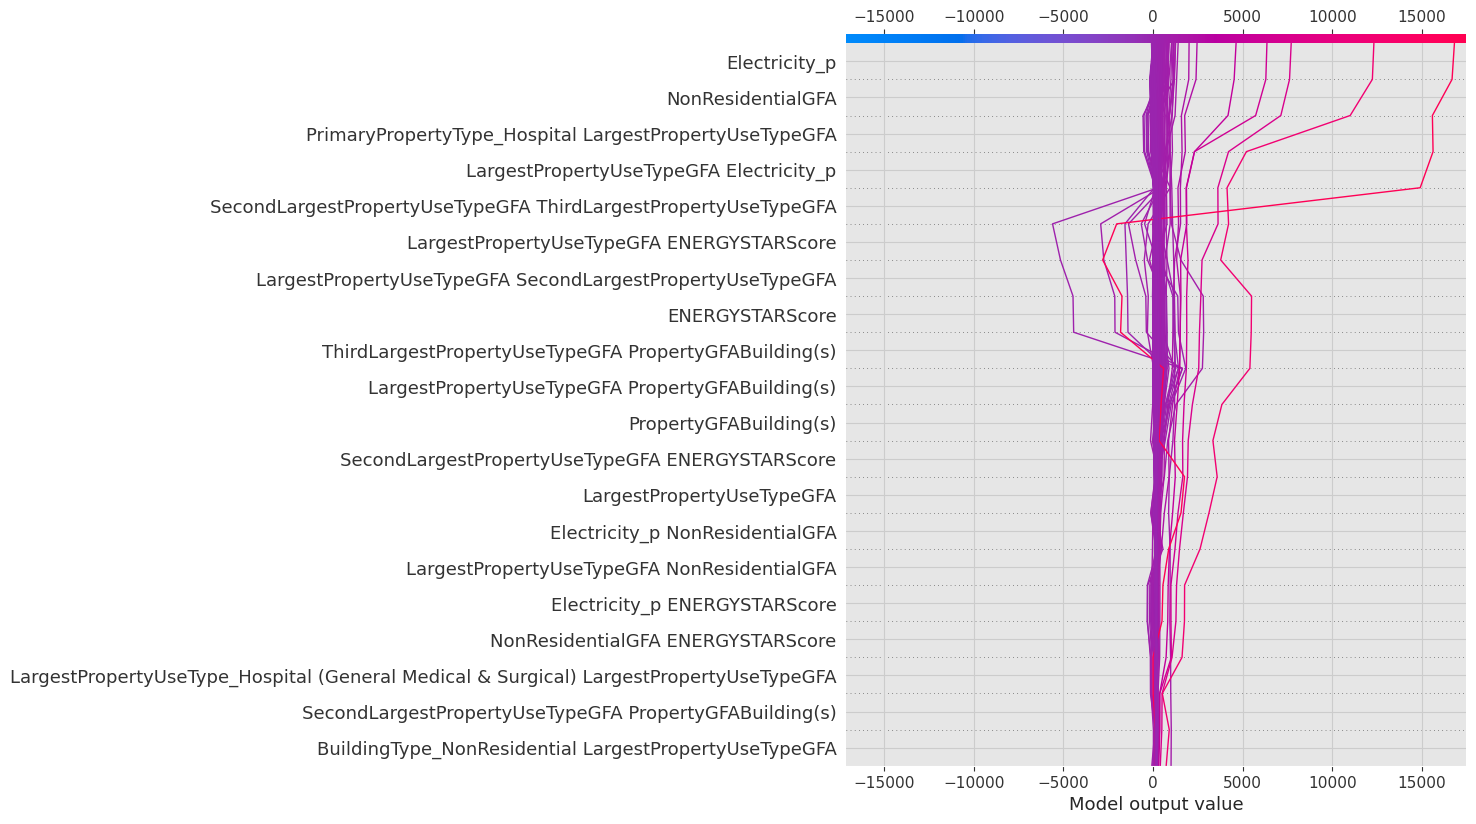

In [70]:
expected_value = linear_shap_explainer.expected_value
shap_values = linear_shap_values.values
shap.decision_plot(expected_value,
                   shap_values,
                   linear_x_train,
                   )

In [71]:
#sur une valeur spécifique
y_pred = (shap_values.sum(1) + expected_value) > 0


In [72]:
#comparaison avec la shap_valu obtenu via 

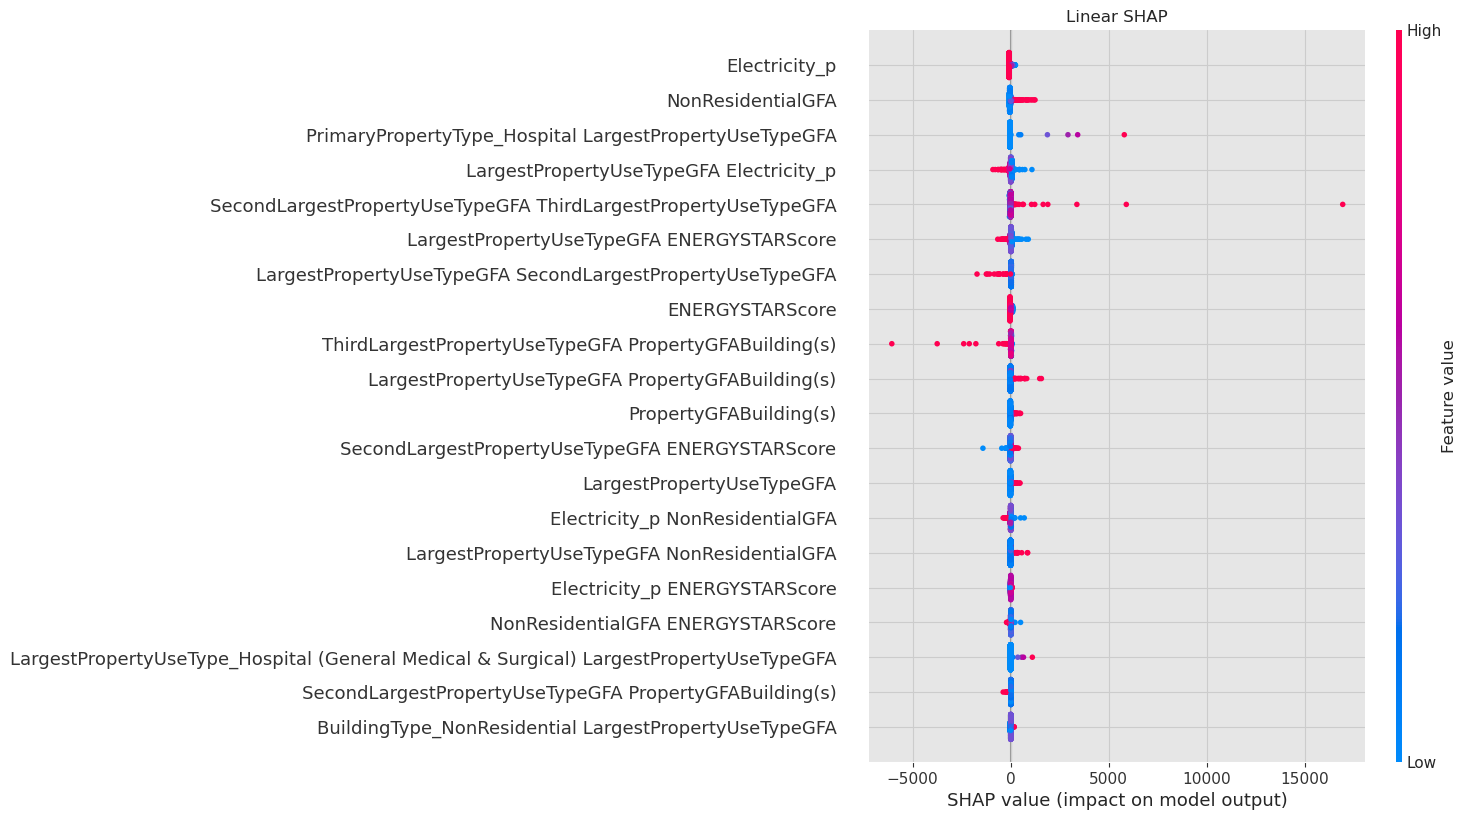

In [73]:
shap.summary_plot(
    shap_values=linear_shap_values,
    features=linear_x_train, 
    show=False
)
plt.title(f'Linear SHAP');

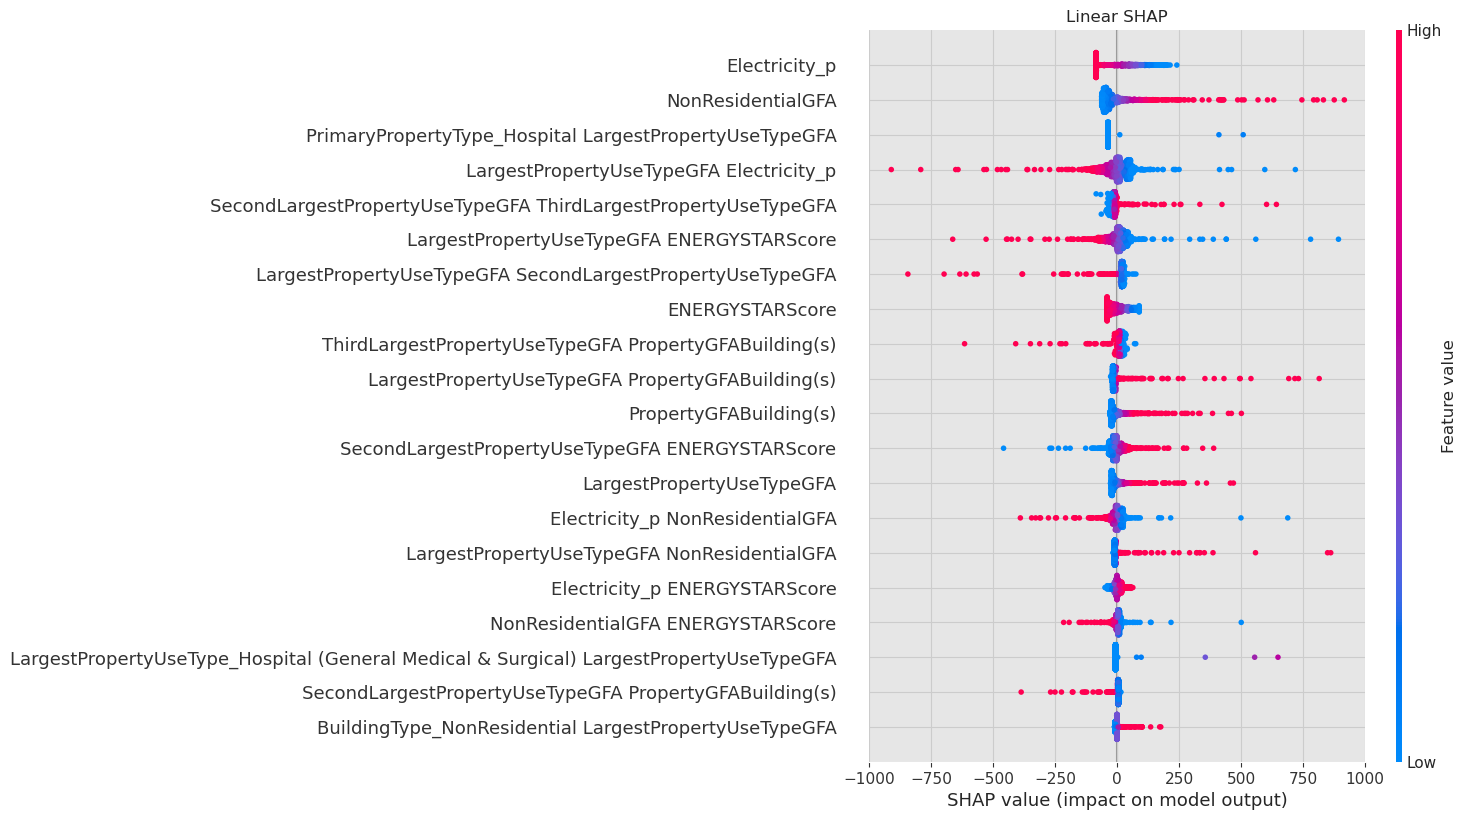

In [74]:
shap.summary_plot(
    shap_values=linear_shap_values,
    features=linear_x_train, 
    show=False
)
plt.xlim(-1000,+1000)
plt.title(f'Linear SHAP');

In [98]:
shap.initjs()
obs_index = 15
shap.force_plot(linear_shap_explainer.expected_value,
                linear_shap_values.values[obs_index,:],
                linear_x_train.iloc[obs_index,:], 
                plot_cmap="DrDb")

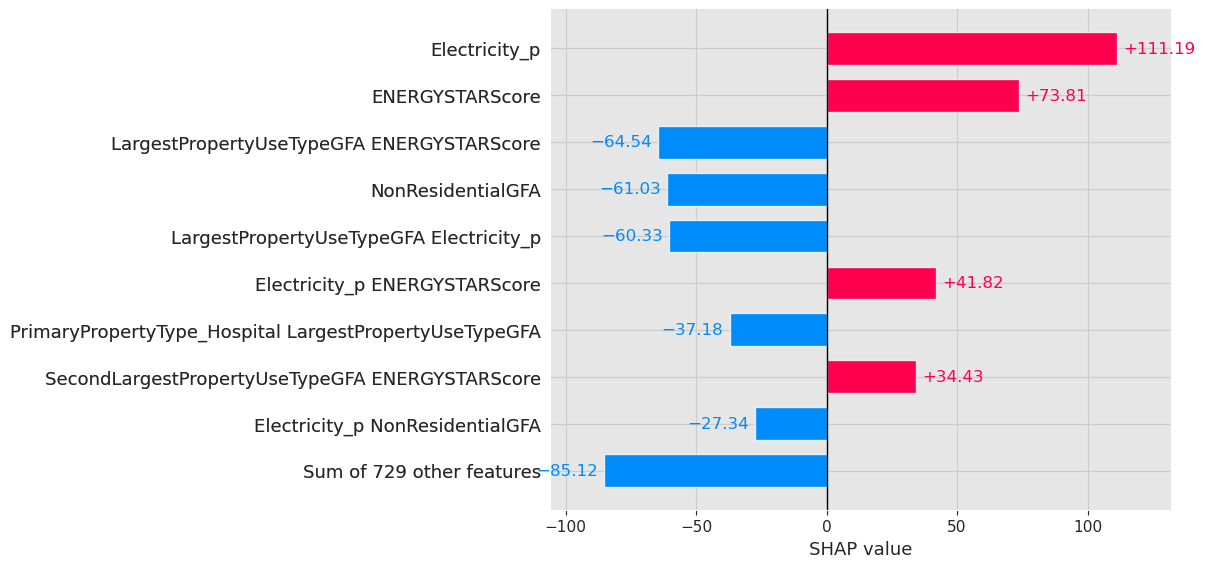

In [78]:
shap.plots.bar(linear_shap_values[obs_index])

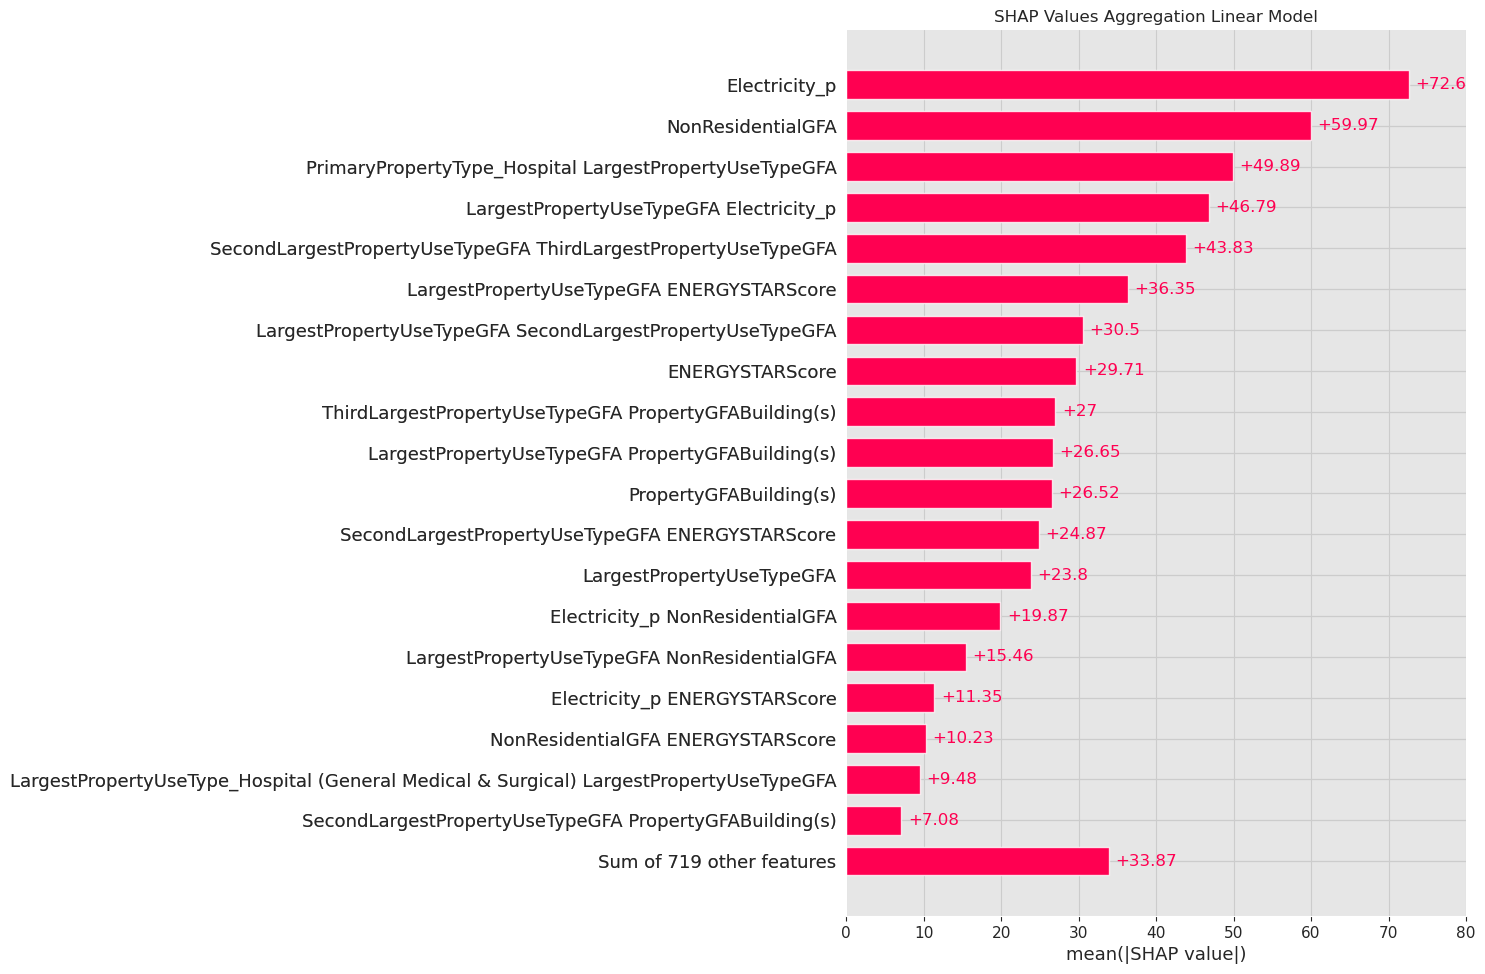

In [80]:
shap.plots.bar(shap_values=linear_shap_values, max_display=20, show=False)
plt.title('SHAP Values Aggregation Linear Model');

In [ ]:
energystarscore = ["Good" if linear_shap_values[i,"ENERGYSTARScore"].data > 0 else "Bad" for i in range(linear_shap_values.shape[0])]
shap.plots.bar(linear_shap_values.cohorts(energystarscore).abs.mean(0))

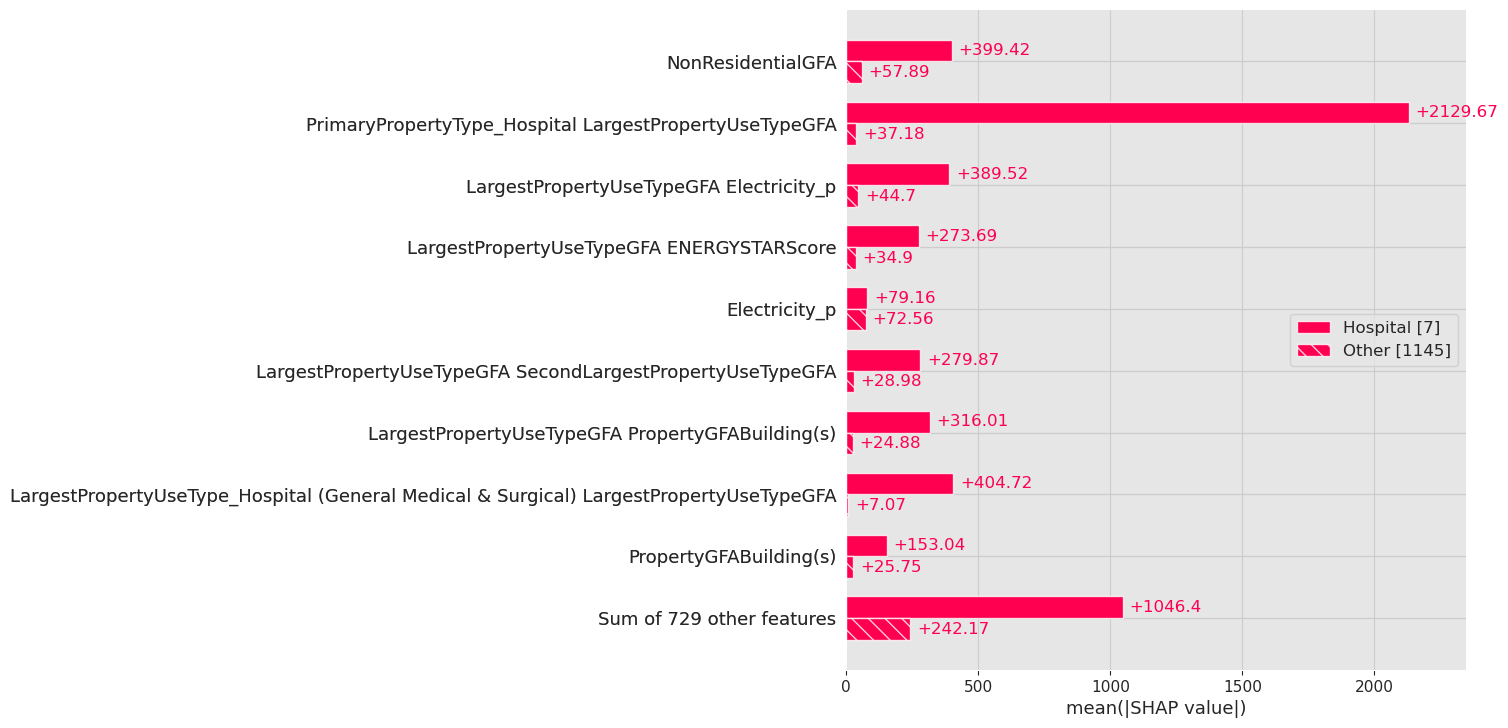

In [82]:
hospital = ["Hospital" if linear_shap_values[i,'PrimaryPropertyType_Hospital'].data == 1 else "Other" for i in range(linear_shap_values.shape[0])]
shap.plots.bar(linear_shap_values.cohorts(hospital).abs.mean(0))

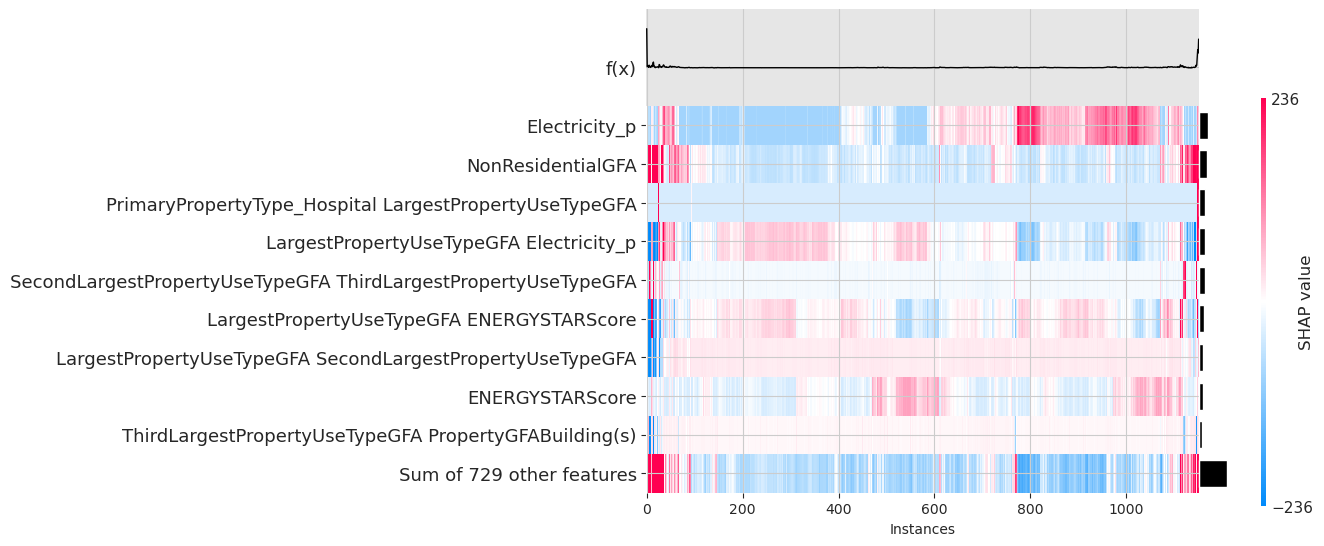

In [83]:
shap.plots.heatmap(linear_shap_values)

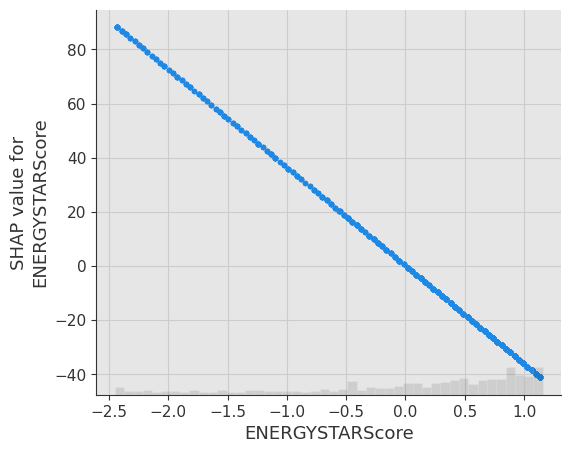

In [84]:
shap.plots.scatter(linear_shap_values[:,"ENERGYSTARScore"])

In [85]:
idx_1 = np.argwhere(np.array(linear_features) == 'ENERGYSTARScore')[0][0]
idx_1

58

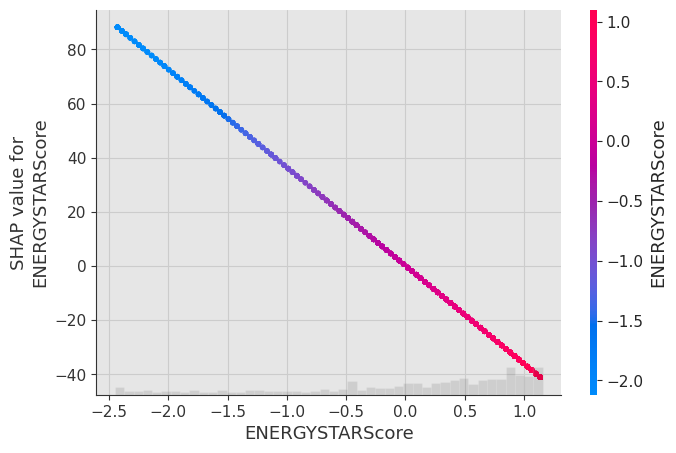

In [86]:
shap.plots.scatter(
    shap_values=linear_shap_values[:, idx_1],
    color=linear_shap_values[:, idx_1]
)

In [87]:
idx_2 = np.argwhere(np.array(linear_features) == 'Electricity_p')[0][0]
idx_2

51

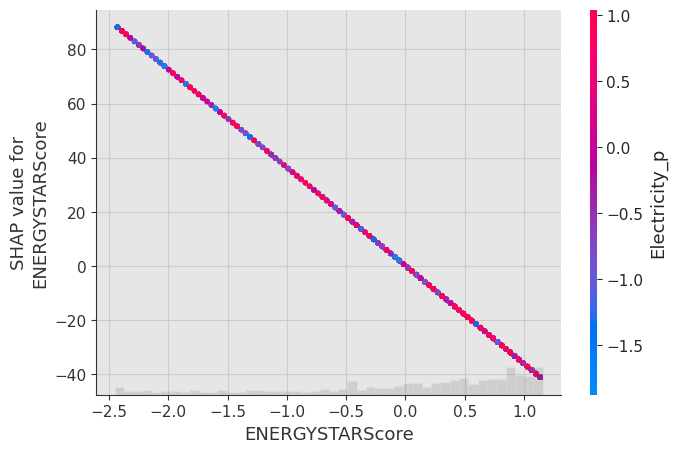

In [88]:
shap.plots.scatter(
    shap_values=linear_shap_values[:, idx_1],
    color=linear_shap_values[:, idx_2]
)

### Pour une observatin spécifique

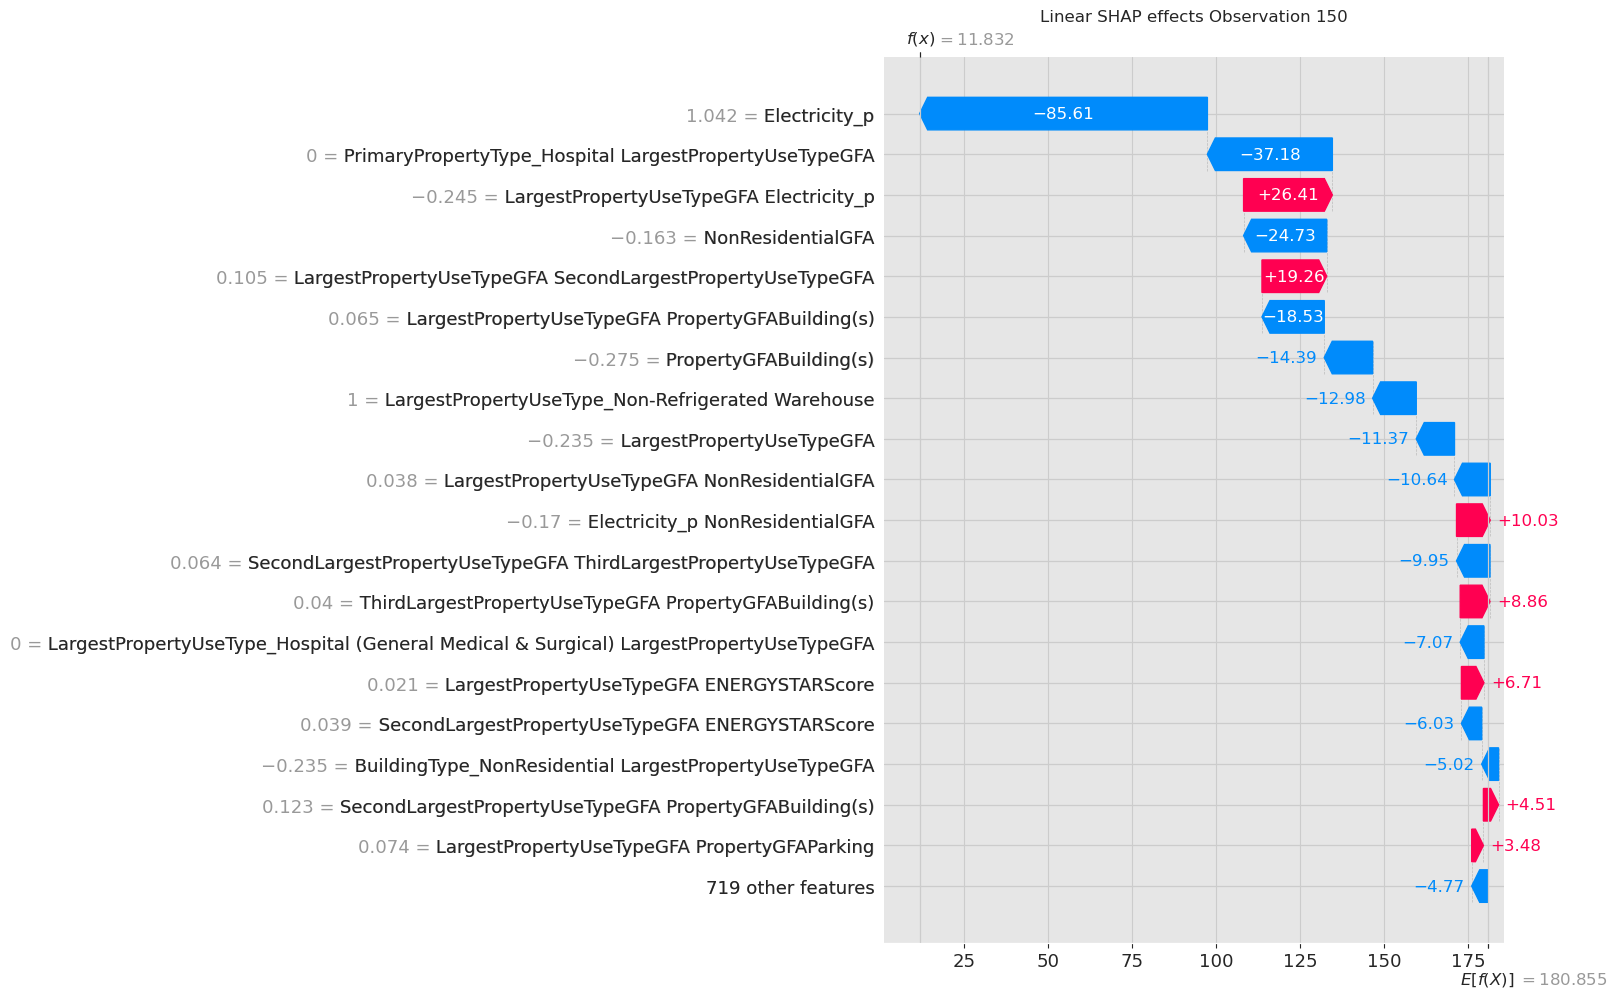

In [89]:
obs_index = 150
shap.plots.waterfall(
    shap_values=linear_shap_values[obs_index],
    max_display=20,
    show=False
)
plt.title(f'Linear SHAP effects Observation {obs_index}');

In [91]:
inds = shap.utils.potential_interactions(linear_shap_values[:, "ENERGYSTARScore"], linear_shap_values)

In [92]:
inds[0:10]

array([426, 391, 419, 175, 552, 178, 381, 166,   8, 167])

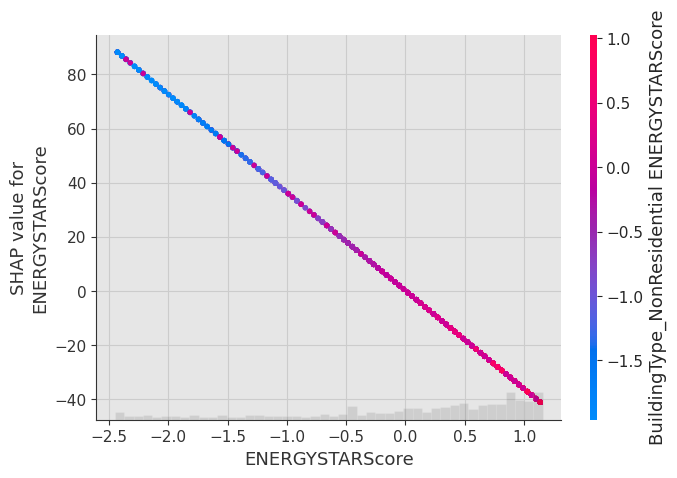

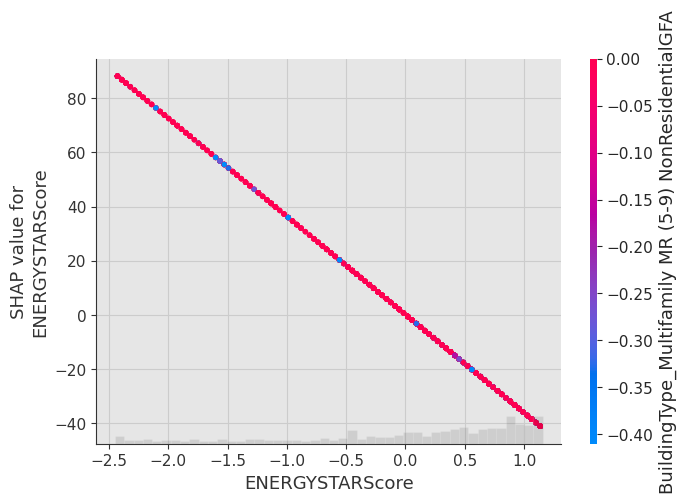

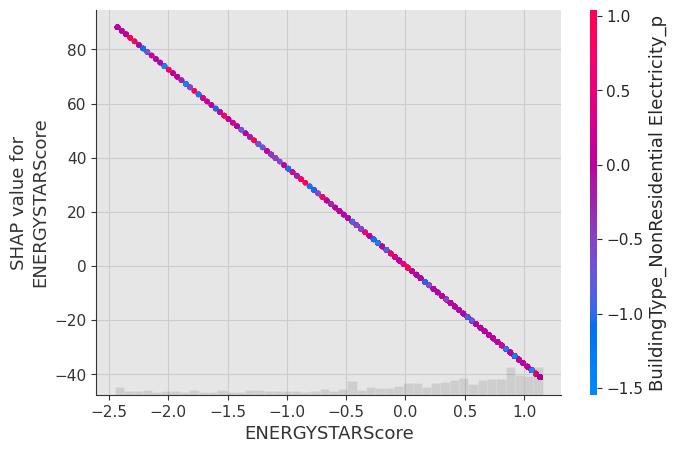

In [93]:
for i in range(3):
    shap.plots.scatter(linear_shap_values[:,"ENERGYSTARScore"], color=linear_shap_values[:,inds[i]])

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

In [ ]:
y_train_pred = linear_pipeline.predict(X_train)

In [ ]:
pd.Series(y_train_pred)

In [ ]:
pd.Series(y_train_pred)[obs_index]

In [ ]:
y_train.sum()/len(y_train)

In [ ]:
X_train.shape

In [ ]:
linear_shap_values[0].values.sum()

# Brouillon

In [ ]:
Ridge().__dict__.keys()

In [ ]:
X_sp = preprocessor.fit_transform(X)

In [ ]:
columns = preprocessor.get_feature_names_out()
X_sp_df = pd.DataFrame(data=X_sp, columns=columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sp, y, test_size = 0.4)

In [ ]:
ridge=Ridge()
params_grid = {
    'fit_intercept' : [True, False],
    'alpha' :[0.1,1,10,100]
}
scoring = 'neg_mean_squared_error'
gs = GridSearchCV(ridge, params_grid,cv= 10, scoring= scoring)
gs.fit(X_train,y_train)
gs.best_params_

In [ ]:
Ridge().get_params().keys()

In [ ]:
ridge.set_params(**gs.best_params_).fit(X_train,y_train)

In [ ]:
ridge.score(X_test,y_test)

In [ ]:
y_train_pred = ridge.predict(X_train)

In [ ]:
y_train_pred.reshape(-1).shape

In [ ]:
data = {'y_train': pd.Series(y_train.values.reshape(-1)), 'y_train_pred' : pd.Series(y_train_pred.reshape(-1)) }
df_graph = pd.DataFrame(data)
df_graph['error'] = df_graph['y_train'] - df_graph['y_train_pred'] 
df_graph = df_graph.sort_values(by = 'error', ascending = False)
df_graph.reset_index(inplace = True)

In [ ]:
df_graph

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(data = df_graph['error'])
sns.lineplot(data = df_graph['y_train'])

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(data=y_train_pred.reshape(-1),
             color='red',
             label='linear',
             alpha = 0.8
            )

sns.lineplot(data=y_train.values.reshape(-1),
             color='purple',
             label='y_train'
)

ax.set(title='In-Sample Predictions')
plt.show()

## Permutation Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
perm = PermutationImportance(linear_grid_search,
                             scoring = scoring,
                             n_iter = 10).fit(X_test, y_test)

In [ ]:
perm.__dict__.keys()

In [ ]:
scoring = 'neg_root_mean_squared_error'
feature_names = preprocessor.get_feature_names_out()
eli5.show_weights(perm,feature_names = feature_names)

### interpretation

## Partials Plots

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [ ]:
PartialDependenceDisplay.__dict__.keys()

In [ ]:
X_sp_df.columns.get_loc('ENERGYSTARScore')

In [ ]:
X_sp_df.columns[11]

In [ ]:
disp1 = PartialDependenceDisplay.from_estimator(ridge, X_test, [11])
plt.xlabel(X_sp_df.columns[11])
plt.show()

In [ ]:
pd_results = partial_dependence(ridge, X_test, features = 11,
                               kind ='both', grid_resolution = 5)

In [ ]:
pd_results.keys()

In [ ]:
pd_results['individual'].shape

In [ ]:
PartialDependenceDisplay.__dict__.keys()

## analyse shap

In [ ]:
X1000 = shap.utils.sample(X_train,1000)

### model coefficient

In [ ]:
print("Model coefficients :\n")
for i in range(X_train.shape[1]):
    print(columns[i],"=", ridge.coef_[0][i].round(3))

## ENERGYSTARScore

In [ ]:
shap.partial_dependence_plot("ENERGYSTARScore",
                             ridge.predict,
                             X1000, 
                             ice = False,
                             model_expected_value = True,
                             feature_expected_value)

In [ ]:
shap.partial_dependence_plot(
    "ENERGYSTARScore", ridge.predict, X1000, ice=False,
    model_expected_value=True, feature_expected_value=True,
    feature_names = columns
)

In [ ]:
explainer = shap.Explainer(ridge.predict, X1000)
shap_values = explainer(X_train)

In [ ]:
shap_values.values[]

In [ ]:
#pour l'indice 20:
sample_ind = 20
shap.partial_dependence_plot(
    "ENERGYSTARScore", ridge.predict, X1000, ice=False,
    model_expected_value=True, feature_expected_value=True,
    feature_names = columns, 
    shap_values=shap_values[20:21,:]
)

In [ ]:
shap.plots.scatter(shap_values[:,"ENERGYSTARScore"])

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257797.69305118383, tolerance: 13935.529221572448
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266888.5114115271, tolerance: 48122.18371085918
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269351.19229748775, tolerance: 48122.18371085918
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective d

[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.00206913808111479; total time=  14.5s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.018329807108324356; total time=  13.1s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.07847599703514611; total time=  11.7s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.6951927961775606; total time=   3.1s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=2.976351441631316; total time=   1.8s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=26.366508987303554; total time=   0.3s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=112.88378916846884; total time=   0.1s
[CV] END linear_feature_engineering__polynomial__int

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176399.11068651106, tolerance: 57828.9382662398
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190058.3808786897, tolerance: 57828.9382662398
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287375.3392341484, tolerance: 48122.18371085918
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did n

[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.001; total time=  14.8s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.0379269019073225; total time=  12.2s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.0379269019073225; total time=  12.9s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.6951927961775606; total time=   1.5s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=1.438449888287663; total time=   1.5s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=2.976351441631316; total time=   0.6s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=6.158482110660261; total time=   0.4s
[CV] END linear_feature_engineering__polynomial__interaction_only=True,

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214255.45730473203, tolerance: 48122.18371085918
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316329.97745307547, tolerance: 13935.529221572448
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168857.47999645316, tolerance: 57828.9382662398
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective d

[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.001; total time=  14.4s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.008858667904100823; total time=  13.9s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.1623776739188721; total time=  11.3s
[CV] END linear_feature_engineering__polynomial__interaction_only=True, linear_regressor__alpha=0.6951927961775606; total time=   7.6s
[CV] END linear_feature_engineering__polynomial__interaction_only=False, linear_regressor__alpha=0.004281332398719396; total time=  15.5s
[CV] END linear_feature_engineering__polynomial__interaction_only=False, linear_regressor__alpha=0.018329807108324356; total time=  15.3s
[CV] END linear_feature_engineering__polynomial__interaction_only=False, linear_regressor__alpha=0.1623776739188721; total time=  12.6s
[CV] END linear_feature_engineering__polynomial__interactio

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251106.27663114492, tolerance: 13935.529221572448
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290222.4306203334, tolerance: 13935.529221572448
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194787.43971086357, tolerance: 48122.18371085918
  positive,
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective 